# **Yield Comparison between FAO and Pangaea Data**

## **Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from tqdm.auto import tqdm
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = "Times New Roman"

## **Read the FAO Yield Data**

In [39]:
# read the FAO yield data
fao_data_path = r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\FAOSTAT_data_SSA_Maize_1961-2022.csv"
fao_yield_df = pd.read_csv(fao_data_path)
fao_yield_df.rename(columns={
    'Area': 'country',
    'Year': 'year',
    'Yield(tons/ha)': 'fao_yield(t/ha)',
    'Element': 'element',
    'Item': 'crop'
}, inplace=True)
print(fao_yield_df.shape)
fao_yield_df.head()

(3043, 5)


country element          crop  year  fao_yield(t/ha)
0  Algeria   Yield  Maize (corn)  1961           0.9746
1  Algeria   Yield  Maize (corn)  1962           0.5400
2  Algeria   Yield  Maize (corn)  1963           1.0716
3  Algeria   Yield  Maize (corn)  1964           1.1703
4  Algeria   Yield  Maize (corn)  1965           1.1000

In [40]:
# Change the name of the few countries 
new_country_names = {
    "C?te d'Ivoire": "Cote d'Ivoire",
    'Eswatini': 'Swaziland',
    'Cabo Verde': 'Cape Verde'
}

fao_yield_df.replace(to_replace=new_country_names, inplace=True)
print(fao_yield_df.shape)
fao_yield_df.head()

(3043, 5)


country element          crop  year  fao_yield(t/ha)
0  Algeria   Yield  Maize (corn)  1961           0.9746
1  Algeria   Yield  Maize (corn)  1962           0.5400
2  Algeria   Yield  Maize (corn)  1963           1.0716
3  Algeria   Yield  Maize (corn)  1964           1.1703
4  Algeria   Yield  Maize (corn)  1965           1.1000

In [41]:
# Check the number of countries in the FAO data
print("Number of countries in the FAO data:", fao_yield_df["country"].nunique())

Number of countries in the FAO data: 53


## **Read the Africa Shapefile**

In [5]:
# Read the africa shapefile
africa_shp_path = r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\Africa_Country_Boundary\afr_g2014_2013_0.shp"
africa_gdf = gpd.read_file(africa_shp_path)
print(africa_gdf.shape)
africa_gdf.head()

(59, 25)


ADM0_CODE     ADM0_NAME CONTINENT ISO3 ISO2    UNI UNDP  FAOSTAT  GAUL  \
0          6         Sudan    Africa  SDN   SD  729.0  SUD    276.0   6.0   
1          8        Angola    Africa  AGO   AO   24.0  ANG      7.0   8.0   
2         29         Benin    Africa  BEN   BJ  204.0  BEN     53.0  29.0   
3         35      Botswana    Africa  BWA   BW   72.0  BOT     20.0  35.0   
4         42  Burkina Faso    Africa  BFA   BF  854.0  BKF    233.0  42.0   

    RIC_ISO3  ... ECOWAS  IGAD  IOC  SADC  CICOS  ICPAC  BDMS  MOI  crop_area  \
0  ICPAC-SDN  ...      0     4    0     0    0.0   14.0   0.0  NaN       None   
1   BDMS-AGO  ...      0     0    0     6    0.0    0.0  16.0  NaN       None   
2    CRA-BEN  ...      3     0    0     0    0.0    0.0   0.0  NaN       None   
3   BDMS-BWA  ...      0     0    0     6    0.0    0.0  16.0  NaN       None   
4    CRA-BFA  ...      3     0    0     0    0.0    0.0   0.0  NaN       None   

                                            geometry  
0  MULTIPOLYGON (((38.58148 18.02542, 38.58203 18...  
1  MULTIPOLYGON (((11.79481 -16.81925, 11.79375 -...  
2  MULTIPOLYGON (((1.86343 6.28872, 1.86292 6.288...  
3  POLYGON ((25.17447 -17.77881, 25.18476 -17.783...  
4  POLYGON ((-0.45567 15.08082, -0.45411 15.07937...  

[5 rows x 25 columns]

In [6]:
# Check the number of countries in the shapefile
print("Number of countries in the shapefile:", africa_gdf["ADM0_NAME"].nunique())

# Store the name of the countries in a specific variable
shp_countries = africa_gdf["ADM0_NAME"].unique()
shp_countries

Number of countries in the shapefile: 59


array(['Sudan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Cameroon',
       'Cape Verde', 'Central African Republic', 'Chad', 'Comoros',
       'Congo', "Côte d'Ivoire", 'Democratic Republic of the Congo',
       'Djibouti', 'South Sudan', 'Equatorial Guinea', 'Eritrea',
       'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea-Bissau', 'Guinea',
       'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali',
       'Mauritania', 'Mauritius', 'Mozambique', 'Namibia', 'Niger',
       'Nigeria', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia',
       'South Africa', 'Swaziland', 'Togo', 'Uganda',
       'United Republic of Tanzania', 'Zambia', 'Zimbabwe', 'Algeria',
       'Burundi', 'Abyei', 'Libya', 'Morocco', 'Rwanda',
       'Sao Tome and Principe', 'Tunisia', 'Western Sahara',
       "Hala'ib triangle", "Ma'tan al-Sarra", 'Egypt', 'Ilemi triangle'],
      dtype=object)

## **Load the Predicted Data**

In [42]:
pred_train_path = r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\notebooks\diffusion_models\predicted_y_train.csv"
pred_test_path = r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\notebooks\diffusion_models\predicted_y_test.csv"

pred_train_df = pd.read_csv(pred_train_path)
pred_test_df = pd.read_csv(pred_test_path)

# combine both the dataframe
pred_df = pd.concat((pred_train_df, pred_test_df), ignore_index=True)
print(pred_df.shape)
print("Number of unique counties in the data: ", pred_df["country"].nunique())
pred_df.head()

(1294025, 105)
Number of unique counties in the data:  49


point_id  country  year  yield(t/ha)  pred_yield(t/ha)  sampel_1  sampel_2  \
0         0  Algeria  2009     0.757956          1.341812  2.513547 -0.122814   
1         1  Algeria  2009     0.082746         -0.071466  0.983641 -0.895080   
2         2  Algeria  2009     0.000000         -0.174845 -0.334639 -0.845386   
3         3  Algeria  2009     0.029789          0.014803 -0.380262  0.523173   
4         4  Algeria  2009     0.215140         -0.108545  1.727676 -0.279845   

   sampel_3  sampel_4  sampel_5  ...  sampel_91  sampel_92  sampel_93  \
0  1.161866 -0.932869  3.918165  ...   2.450521   0.712487   0.199418   
1 -0.358293 -1.839544  0.015556  ...   0.732009   1.870460  -1.339763   
2 -0.556105 -0.976695  0.094603  ...   0.978995  -1.037073   0.265610   
3 -1.104236  0.891626 -1.241283  ...  -0.930354  -0.229941  -0.129272   
4 -1.043369 -0.131013 -0.611467  ...   0.251302  -2.002021   1.257798   

   sampel_94  sampel_95  sampel_96  sampel_97  sampel_98  sampel_99  \
0   1.989121   1.560051  -0.187690   0.566613   0.861372   0.497439   
1  -0.800943  -0.670018   0.716341  -0.139020  -0.051021  -0.524440   
2   0.568146  -2.228491  -0.143725  -0.520269   0.133108   1.479850   
3   1.232681  -0.521663  -1.173461   2.166491   0.690511  -1.508349   
4   0.408578   0.029903   1.161273  -0.011030   0.016849   1.027923   

   sampel_100  
0    1.540482  
1   -3.284086  
2    0.309702  
3    1.050887  
4    0.890261  

[5 rows x 105 columns]

In [43]:
# compare the prediction with FAO yield
pred_df = pred_df.iloc[:, 1:5].groupby(["country", "year"]).mean()
pred_df.reset_index(inplace=True)
print(pred_df.shape)
pred_df.head()

(675, 4)


country  year  yield(t/ha)  pred_yield(t/ha)
0  Algeria  2009     3.087488          2.766328
1  Algeria  2010     2.579863          2.913245
2  Algeria  2011     2.318875          3.052844
3  Algeria  2012     2.553276          4.425983
4  Algeria  2013     3.351099          2.869834

In [44]:
yield_comparison = pd.merge(left=pred_df, right=fao_yield_df, on=["country", "year"])
print(yield_comparison.shape)
yield_comparison.head()

(675, 7)


country  year  yield(t/ha)  pred_yield(t/ha) element          crop  \
0  Algeria  2009     3.087488          2.766328   Yield  Maize (corn)   
1  Algeria  2010     2.579863          2.913245   Yield  Maize (corn)   
2  Algeria  2011     2.318875          3.052844   Yield  Maize (corn)   
3  Algeria  2012     2.553276          4.425983   Yield  Maize (corn)   
4  Algeria  2013     3.351099          2.869834   Yield  Maize (corn)   

   fao_yield(t/ha)  
0           3.0914  
1           2.5827  
2           2.3374  
3           2.5583  
4           3.3649

In [ ]:
def getPerformanceMetrics(data: pd.DataFrame, actual_col: str, predicted_col: str):

  r2 =  r2_score(data[actual_col], data[predicted_col])
  mae = mean_absolute_error(data[actual_col], data[predicted_col])
  rmse = np.sqrt(mean_squared_error(data[actual_col], data[predicted_col]))

  print("R2 Score:", r2)
  print("MAE:", mae)
  print("RMSE:", rmse)

## **Read the Pangaea Yield Data**

In [10]:
# Read the Pangaea yield data
yield_data_path = r"D:\Research Works\Agriculture\Africa\Africa_paper\Crops_Yield\maize.csv"
yield_df = pd.read_csv(yield_data_path)
print(yield_df.shape)
yield_df.head()

(10226, 38)


Lon    Lat  1981  1982  1983  1984  1985  1986  1987  1988  ...  2007  \
0 -24.75  16.75   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1 -23.75  15.25   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
2 -17.25  14.75   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
3 -16.75  12.75   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4 -16.75  13.25   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   

   2008  2009  2010  2011  2012  2013  2014  2015  2016  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 38 columns]

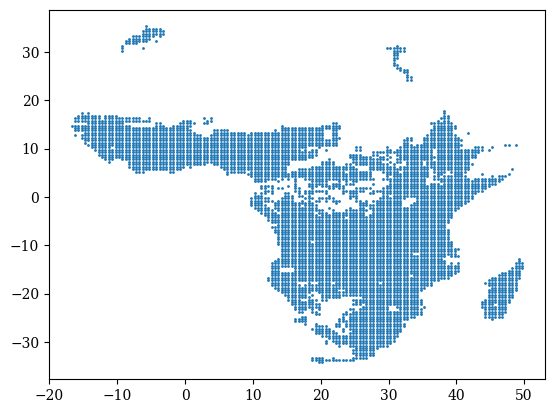

In [20]:
plt.scatter(x=yield_df["Lon"], y=yield_df["Lat"], s=1)

In [11]:
# Drop the rows with null values across all years
null_rows_index = yield_df.iloc[:, 2:].isnull().sum(axis=1)
null_rows_index = null_rows_index[null_rows_index==36].index

# Drop the null rows from the dataframe
yield_df.drop(index=null_rows_index, inplace=True)
print(yield_df.shape)
yield_df.head()

(5082, 38)


Lon    Lat      1981      1982      1983      1984      1985      1986  \
6  -16.75  14.75  0.472825  0.376438  0.206165  0.306877  0.561544  0.291398   
11 -16.25  12.75  1.433674  1.227325  1.168139  1.873190  1.864365  1.473679   
13 -16.25  13.75  0.873517  0.644513  0.508204  0.843970  0.978451  0.758092   
14 -16.25  14.25  0.780837  0.505755  0.309610  0.586465  0.868196  0.592568   
15 -16.25  14.75  0.439209  0.344943  0.213096  0.270765  0.438526  0.261500   

        1987      1988  ...      2007      2008      2009      2010      2011  \
6   0.372327  0.327649  ...  0.295032  0.533454  0.609084  0.548866  0.273706   
11  1.464842  1.436291  ...  1.454072  2.212240  1.927233  1.779845  1.506943   
13  0.735792  0.665472  ...  0.587343  1.092225  0.975417  0.925198  0.601326   
14  0.523936  0.490515  ...  0.399388  0.883483  0.714394  0.766167  0.424743   
15  0.302742  0.300420  ...  0.205778  0.634867  0.539136  0.486485  0.316431   

        2012      2013      2014      2015      2016  
6   0.655873  0.408065  0.317520  0.582995  0.529290  
11  1.810503  1.733871  1.648368  1.999163  2.100773  
13  0.957940  0.740045  0.727029  0.840273  1.068431  
14  0.716934  0.690992  0.389206  0.715049  0.570394  
15  0.662432  0.548353  0.250637  0.706258  0.605660  

[5 rows x 38 columns]

In [12]:
# Convert the yield data into geodataframe
yield_df_geometry = [Point(xy) for xy in zip(yield_df["Lon"], yield_df["Lat"])]

yield_gdf = gpd.GeoDataFrame(yield_df, geometry=yield_df_geometry, crs="EPSG:4326")
print(yield_gdf.shape)
yield_gdf.head()

(5082, 39)


Lon    Lat      1981      1982      1983      1984      1985      1986  \
6  -16.75  14.75  0.472825  0.376438  0.206165  0.306877  0.561544  0.291398   
11 -16.25  12.75  1.433674  1.227325  1.168139  1.873190  1.864365  1.473679   
13 -16.25  13.75  0.873517  0.644513  0.508204  0.843970  0.978451  0.758092   
14 -16.25  14.25  0.780837  0.505755  0.309610  0.586465  0.868196  0.592568   
15 -16.25  14.75  0.439209  0.344943  0.213096  0.270765  0.438526  0.261500   

        1987      1988  ...      2008      2009      2010      2011      2012  \
6   0.372327  0.327649  ...  0.533454  0.609084  0.548866  0.273706  0.655873   
11  1.464842  1.436291  ...  2.212240  1.927233  1.779845  1.506943  1.810503   
13  0.735792  0.665472  ...  1.092225  0.975417  0.925198  0.601326  0.957940   
14  0.523936  0.490515  ...  0.883483  0.714394  0.766167  0.424743  0.716934   
15  0.302742  0.300420  ...  0.634867  0.539136  0.486485  0.316431  0.662432   

        2013      2014      2015      2016                    geometry  
6   0.408065  0.317520  0.582995  0.529290  POINT (-16.75000 14.75000)  
11  1.733871  1.648368  1.999163  2.100773  POINT (-16.25000 12.75000)  
13  0.740045  0.727029  0.840273  1.068431  POINT (-16.25000 13.75000)  
14  0.690992  0.389206  0.715049  0.570394  POINT (-16.25000 14.25000)  
15  0.548353  0.250637  0.706258  0.605660  POINT (-16.25000 14.75000)  

[5 rows x 39 columns]

## **Compare the Yields between Pangaea and FAO Data**

In [163]:
# Write a function to compare the yield
def compare_fao_and_pangaea(roi_shp, fao_df, pangaea_gdf, coutries):

    # Create a blank dataframe to store the data for all the countries
    final_merged_df = pd.DataFrame()
    point_count = {}

    for country in tqdm(coutries):
        print(country)
        country_geom = roi_shp[roi_shp["ADM0_NAME"]==country]
        country_geom = country_geom[["ADM0_NAME", "geometry"]]

        # Extract the Pangaea yield
        points_gdf = gpd.sjoin(country_geom, pangaea_gdf, how="inner", predicate="intersects")
        print(f"Number of points falling in {country}:", points_gdf.shape[0])
        point_count[country] = points_gdf.shape[0]
        points_df = points_gdf.iloc[:, 5:]
        yearly_yield = points_df.mean(axis=0)
        pangaea_yearly_yield_df = pd.DataFrame({"Year": yearly_yield.index, "Pangaea_Yield(tons/ha)": yearly_yield.values})
        pangaea_yearly_yield_df.dropna(inplace=True)
        pangaea_yearly_yield_df = pangaea_yearly_yield_df.astype("float32")

        # Extract the FAO yield data for the country
        country_fao_yield = fao_df[fao_df["Area"]==country]

        # Merge both the dataframe
        yield_merged = pd.merge(left=country_fao_yield, right=pangaea_yearly_yield_df, how="inner", on="Year")
        yield_merged.rename(columns={"Yield(tons/ha)": "FAO_Yield(tons/ha)"}, inplace=True)
        print("Done.\n")

        final_merged_df = pd.concat((final_merged_df, yield_merged), axis=0)
        final_merged_df.sort_values(by=["Area", "Year"], inplace=True)

    point_count_df = pd.DataFrame({"Area":point_count.keys(), "No_of_Points": point_count.values()})
    return final_merged_df, point_count_df

In [164]:
# Apply the function
merged_df, point_count_df = compare_fao_and_pangaea(roi_shp=filtered_africa_gdf, 
                                                    fao_df=fao_df,
                                                    pangaea_gdf=yield_gdf,
                                                    coutries=common_countries)
merged_df

 10%|█         | 5/49 [00:00<00:00, 48.27it/s]

Lesotho
Number of points falling in Lesotho: 12
Done.

Angola
Number of points falling in Angola: 391
Done.

Comoros
Number of points falling in Comoros: 0
Done.

Sao Tome and Principe
Number of points falling in Sao Tome and Principe: 0
Done.

Libya
Number of points falling in Libya: 0
Done.

South Africa
Number of points falling in South Africa: 299
Done.

Malawi
Number of points falling in Malawi: 37
Done.

Senegal
Number of points falling in Senegal: 56
Done.

Mauritania


 33%|███▎      | 16/49 [00:00<00:00, 48.23it/s]

Number of points falling in Mauritania: 45
Done.

Cape Verde
Number of points falling in Cape Verde: 0
Done.

Benin
Number of points falling in Benin: 37
Done.

Central African Republic
Number of points falling in Central African Republic: 110
Done.

Botswana
Number of points falling in Botswana: 117
Done.

Mozambique
Number of points falling in Mozambique: 228
Done.

Mali
Number of points falling in Mali: 135
Done.

Algeria
Number of points falling in Algeria: 0
Done.

Chad
Number of points falling in Chad: 167
Done.

Cameroon
Number of points falling in Cameroon: 119
Done.

Djibouti
Number of points falling in Djibouti: 0
Done.

Eritrea


 53%|█████▎    | 26/49 [00:00<00:00, 48.42it/s]

Number of points falling in Eritrea: 23
Done.

Egypt
Number of points falling in Egypt: 33
Done.

Nigeria
Number of points falling in Nigeria: 291
Done.

Guinea
Number of points falling in Guinea: 74
Done.

Sierra Leone
Number of points falling in Sierra Leone: 21
Done.

Gambia
Number of points falling in Gambia: 2
Done.

Ghana
Number of points falling in Ghana: 73
Done.

Somalia
Number of points falling in Somalia: 78
Done.

Burundi
Number of points falling in Burundi: 10
Done.

Niger
Number of points falling in Niger: 21
Done.

Zimbabwe


 78%|███████▊  | 38/49 [00:00<00:00, 52.40it/s]

Number of points falling in Zimbabwe: 135
Done.

Sudan
Number of points falling in Sudan: 21
Done.

United Republic of Tanzania
Number of points falling in United Republic of Tanzania: 291
Done.

Burkina Faso
Number of points falling in Burkina Faso: 87
Done.

Kenya
Number of points falling in Kenya: 173
Done.

Gabon
Number of points falling in Gabon: 54
Done.

Mauritius
Number of points falling in Mauritius: 0
Done.

Rwanda
Number of points falling in Rwanda: 10
Done.

Democratic Republic of the Congo
Number of points falling in Democratic Republic of the Congo: 597
Done.

Togo
Number of points falling in Togo: 17
Done.

Zambia
Number of points falling in Zambia: 250
Done.

Congo
Number of points falling in Congo: 73


 90%|████████▉ | 44/49 [00:00<00:00, 53.23it/s]

Done.

Côte d'Ivoire
Number of points falling in Côte d'Ivoire: 103
Done.

Ethiopia
Number of points falling in Ethiopia: 258
Done.

Morocco
Number of points falling in Morocco: 51
Done.

South Sudan
Number of points falling in South Sudan: 162
Done.

Madagascar
Number of points falling in Madagascar: 166
Done.

Namibia
Number of points falling in Namibia: 163
Done.

Uganda
Number of points falling in Uganda: 74
Done.

Guinea-Bissau
Number of points falling in Guinea-Bissau: 6
Done.



100%|██████████| 49/49 [00:01<00:00, 48.38it/s]


Area Element          Item  Year  FAO_Yield(tons/ha)  \
0     Angola   Yield  Maize (corn)  1981              0.4167   
1     Angola   Yield  Maize (corn)  1982              0.4167   
2     Angola   Yield  Maize (corn)  1983              0.4583   
3     Angola   Yield  Maize (corn)  1984              0.4333   
4     Angola   Yield  Maize (corn)  1985              0.4167   
..       ...     ...           ...   ...                 ...   
30  Zimbabwe   Yield  Maize (corn)  2012              0.7912   
31  Zimbabwe   Yield  Maize (corn)  2013              0.7449   
32  Zimbabwe   Yield  Maize (corn)  2014              0.9301   
33  Zimbabwe   Yield  Maize (corn)  2015              0.5803   
34  Zimbabwe   Yield  Maize (corn)  2016              0.4405   

    Pangaea_Yield(tons/ha)  
0                 0.707304  
1                 0.494969  
2                 0.520497  
3                 0.494311  
4                 0.421358  
..                     ...  
30                0.980557  
31                0.711603  
32                0.878154  
33                0.564656  
34                0.624318  

[1413 rows x 6 columns]

In [165]:
# Merge the Simulated Yield
merged_df.rename(columns={"Area": "Countries"}, inplace=True)
merged_df = pd.merge(left=merged_df, right=simulated_yearly_df, how="left", on=["Countries", "Year"])
print(merged_df.shape)
merged_df.head()

(1413, 7)


Countries Element          Item  Year  FAO_Yield(tons/ha)  \
0    Angola   Yield  Maize (corn)  1981              0.4167   
1    Angola   Yield  Maize (corn)  1982              0.4167   
2    Angola   Yield  Maize (corn)  1983              0.4583   
3    Angola   Yield  Maize (corn)  1984              0.4333   
4    Angola   Yield  Maize (corn)  1985              0.4167   

   Pangaea_Yield(tons/ha)  Simulated_Yield(tons/ha)  
0                0.707304                  1.644172  
1                0.494969                  1.737127  
2                0.520497                  1.643151  
3                0.494311                  1.682614  
4                0.421358                  1.720339

In [166]:
merged_df["Countries"].unique()

array(['Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Congo',
       "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Egypt',
       'Eritrea', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea',
       'Guinea-Bissau', 'Kenya', 'Lesotho', 'Madagascar', 'Malawi',
       'Mali', 'Mauritania', 'Morocco', 'Mozambique', 'Namibia', 'Niger',
       'Nigeria', 'Rwanda', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'South Sudan', 'Sudan', 'Togo', 'Uganda',
       'United Republic of Tanzania', 'Zambia', 'Zimbabwe'], dtype=object)

In [167]:
merged_df[merged_df['Countries']=="Democratic Republic of the Congo"]

Countries Element          Item  Year  \
359  Democratic Republic of the Congo   Yield  Maize (corn)  1981   
360  Democratic Republic of the Congo   Yield  Maize (corn)  1982   
361  Democratic Republic of the Congo   Yield  Maize (corn)  1983   
362  Democratic Republic of the Congo   Yield  Maize (corn)  1984   
363  Democratic Republic of the Congo   Yield  Maize (corn)  1985   
364  Democratic Republic of the Congo   Yield  Maize (corn)  1986   
365  Democratic Republic of the Congo   Yield  Maize (corn)  1987   
366  Democratic Republic of the Congo   Yield  Maize (corn)  1988   
367  Democratic Republic of the Congo   Yield  Maize (corn)  1989   
368  Democratic Republic of the Congo   Yield  Maize (corn)  1990   
369  Democratic Republic of the Congo   Yield  Maize (corn)  1991   
370  Democratic Republic of the Congo   Yield  Maize (corn)  1992   
371  Democratic Republic of the Congo   Yield  Maize (corn)  1993   
372  Democratic Republic of the Congo   Yield  Maize (corn)  1994   
373  Democratic Republic of the Congo   Yield  Maize (corn)  1995   
374  Democratic Republic of the Congo   Yield  Maize (corn)  1996   
375  Democratic Republic of the Congo   Yield  Maize (corn)  1997   
376  Democratic Republic of the Congo   Yield  Maize (corn)  1998   
377  Democratic Republic of the Congo   Yield  Maize (corn)  1999   
378  Democratic Republic of the Congo   Yield  Maize (corn)  2000   
379  Democratic Republic of the Congo   Yield  Maize (corn)  2001   
380  Democratic Republic of the Congo   Yield  Maize (corn)  2002   
381  Democratic Republic of the Congo   Yield  Maize (corn)  2003   
382  Democratic Republic of the Congo   Yield  Maize (corn)  2004   
383  Democratic Republic of the Congo   Yield  Maize (corn)  2005   
384  Democratic Republic of the Congo   Yield  Maize (corn)  2006   
385  Democratic Republic of the Congo   Yield  Maize (corn)  2007   
386  Democratic Republic of the Congo   Yield  Maize (corn)  2008   
387  Democratic Republic of the Congo   Yield  Maize (corn)  2009   
388  Democratic Republic of the Congo   Yield  Maize (corn)  2010   
389  Democratic Republic of the Congo   Yield  Maize (corn)  2011   
390  Democratic Republic of the Congo   Yield  Maize (corn)  2012   
391  Democratic Republic of the Congo   Yield  Maize (corn)  2013   
392  Democratic Republic of the Congo   Yield  Maize (corn)  2014   
393  Democratic Republic of the Congo   Yield  Maize (corn)  2015   
394  Democratic Republic of the Congo   Yield  Maize (corn)  2016   

     FAO_Yield(tons/ha)  Pangaea_Yield(tons/ha)  Simulated_Yield(tons/ha)  
359              0.8334                0.955386                  2.091288  
360              0.8476                1.018123                  2.093963  
361              0.8309                1.002319                  2.048144  
362              0.8471                1.028344                  2.106573  
363              0.8000                0.952737                  2.098102  
364              0.8000                0.993466                  2.099324  
365              0.8500                0.989070                  2.066917  
366              0.8090                1.027129                  2.042014  
367              0.8140                0.992504                  2.098817  
368              0.8166                0.986503                  2.049397  
369              0.8100                1.069856                  2.058678  
370              0.8120                1.027986                  2.071014  
371              0.8257                1.097802                  2.086528  
372              0.8266                1.008093                  2.066707  
373              0.7866                0.968622                  2.048381  
374              0.7994                1.031143                  2.059102  
375              0.8178                1.003746                  2.040931  
376              0.8319                1.062881                  2.002926  
377              0.7990       

In [15]:
# Save the dataframes
output_path = r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\processed_datasets"
# merged_df.to_csv(os.path.join(output_path, "fao_and_pangaea_yield.csv"), index=False)
# point_count_df.to_csv(os.path.join(output_path, "point_per_country.csv"), index=False)

## **Plot the Data**

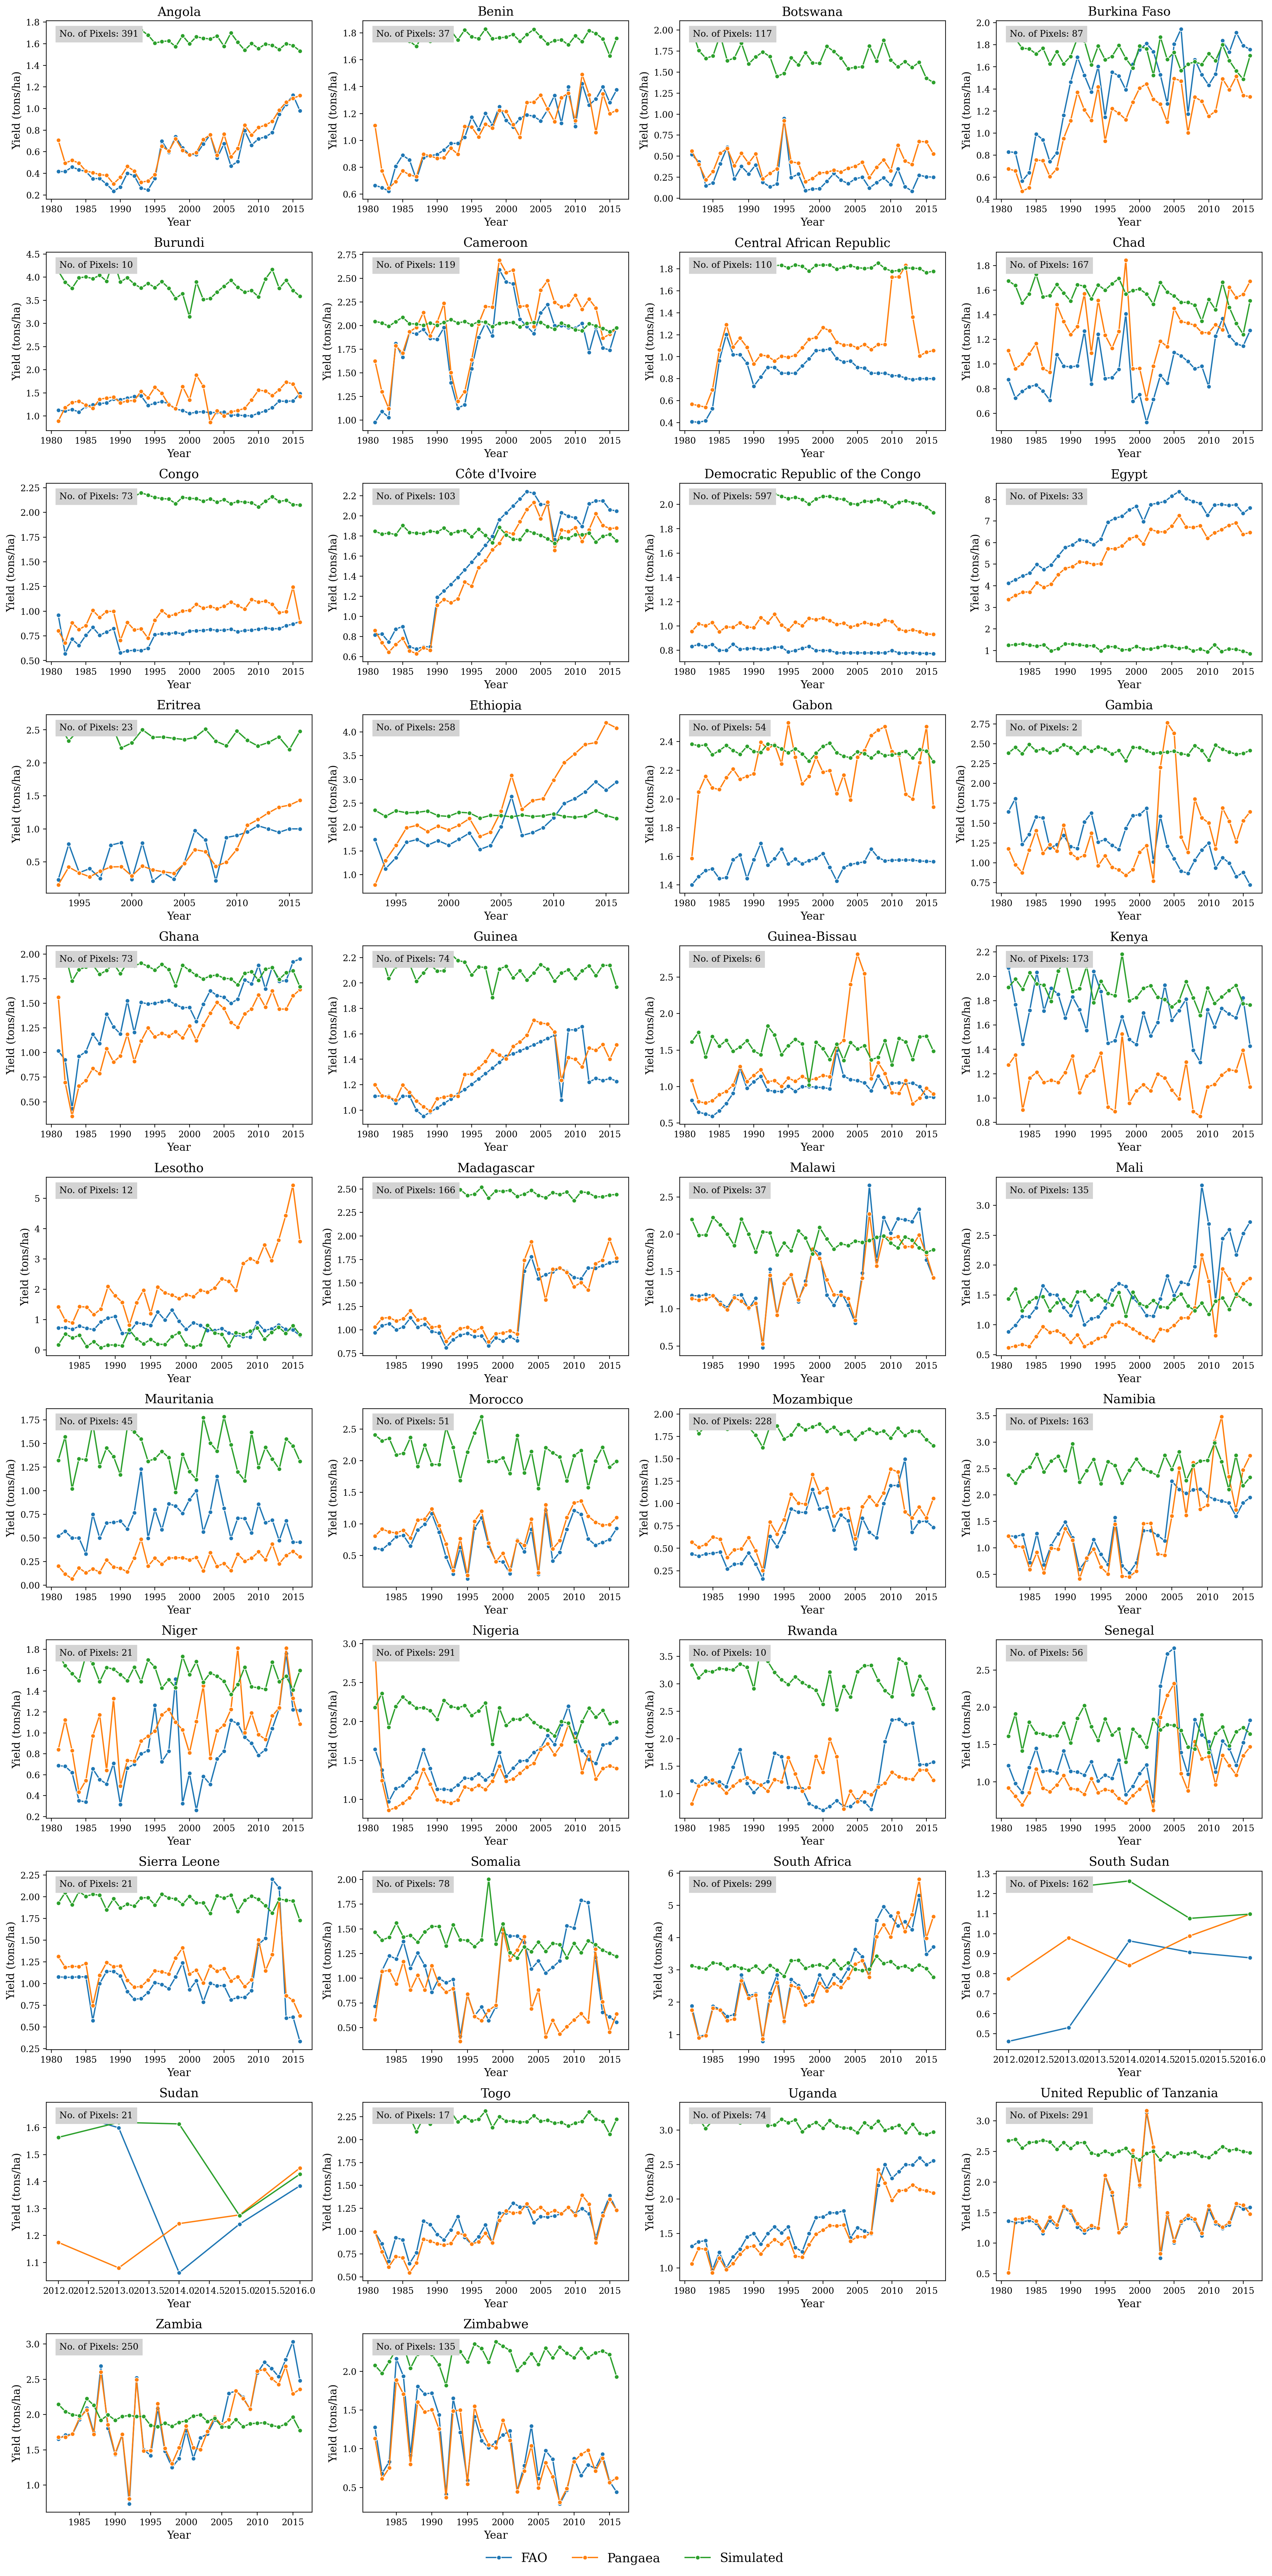

In [168]:
# Plot the timeseries plot
fig, axes = plt.subplots(ncols=4, nrows=11, figsize=(20, 40), dpi=200)
axes = axes.flatten()

for index, country in enumerate(merged_df["Countries"].unique()):
    sns.lineplot(data=merged_df[merged_df["Countries"]==country], x="Year", y="FAO_Yield(tons/ha)",
                 marker="o", markersize=5, ax=axes[index], label="FAO")
    sns.lineplot(merged_df[merged_df["Countries"]==country], x="Year", y="Pangaea_Yield(tons/ha)",
                 marker="o", markersize=5, ax=axes[index], label="Pangaea")
    sns.lineplot(merged_df[merged_df["Countries"]==country], x="Year", y="Simulated_Yield(tons/ha)",
                 marker="o", markersize=5, ax=axes[index], label="Simulated")
    
    number_of_points = point_count_df[point_count_df["Area"]==country]["No_of_Points"].values[0]

    axes[index].set_xlabel("Year", fontsize=12)
    axes[index].set_ylabel("Yield (tons/ha)", fontsize=12)
    axes[index].set_title(country, fontsize=14)

    # Annotate the subplot with RMSE and R^2
    axes[index].text(0.05, 0.95, f'No. of Pixels: {number_of_points}', transform=axes[index].transAxes, verticalalignment='top', backgroundcolor="lightgrey", fontsize=10)

    axes[index].legend().remove()

# Turn off the unused axes
for ax in axes[len(merged_df["Countries"].unique()):]:
    ax.set_visible(False)

# Extract handles and labels from the first subplot with data
handles, labels = axes[0].get_legend_handles_labels()

# Create a single legend for the entire figure
fig.legend(handles, labels, loc='lower center', fontsize=14, ncol=3, bbox_to_anchor=(0.5, -0.01), frameon=False)

plt.tight_layout()
plt.show()

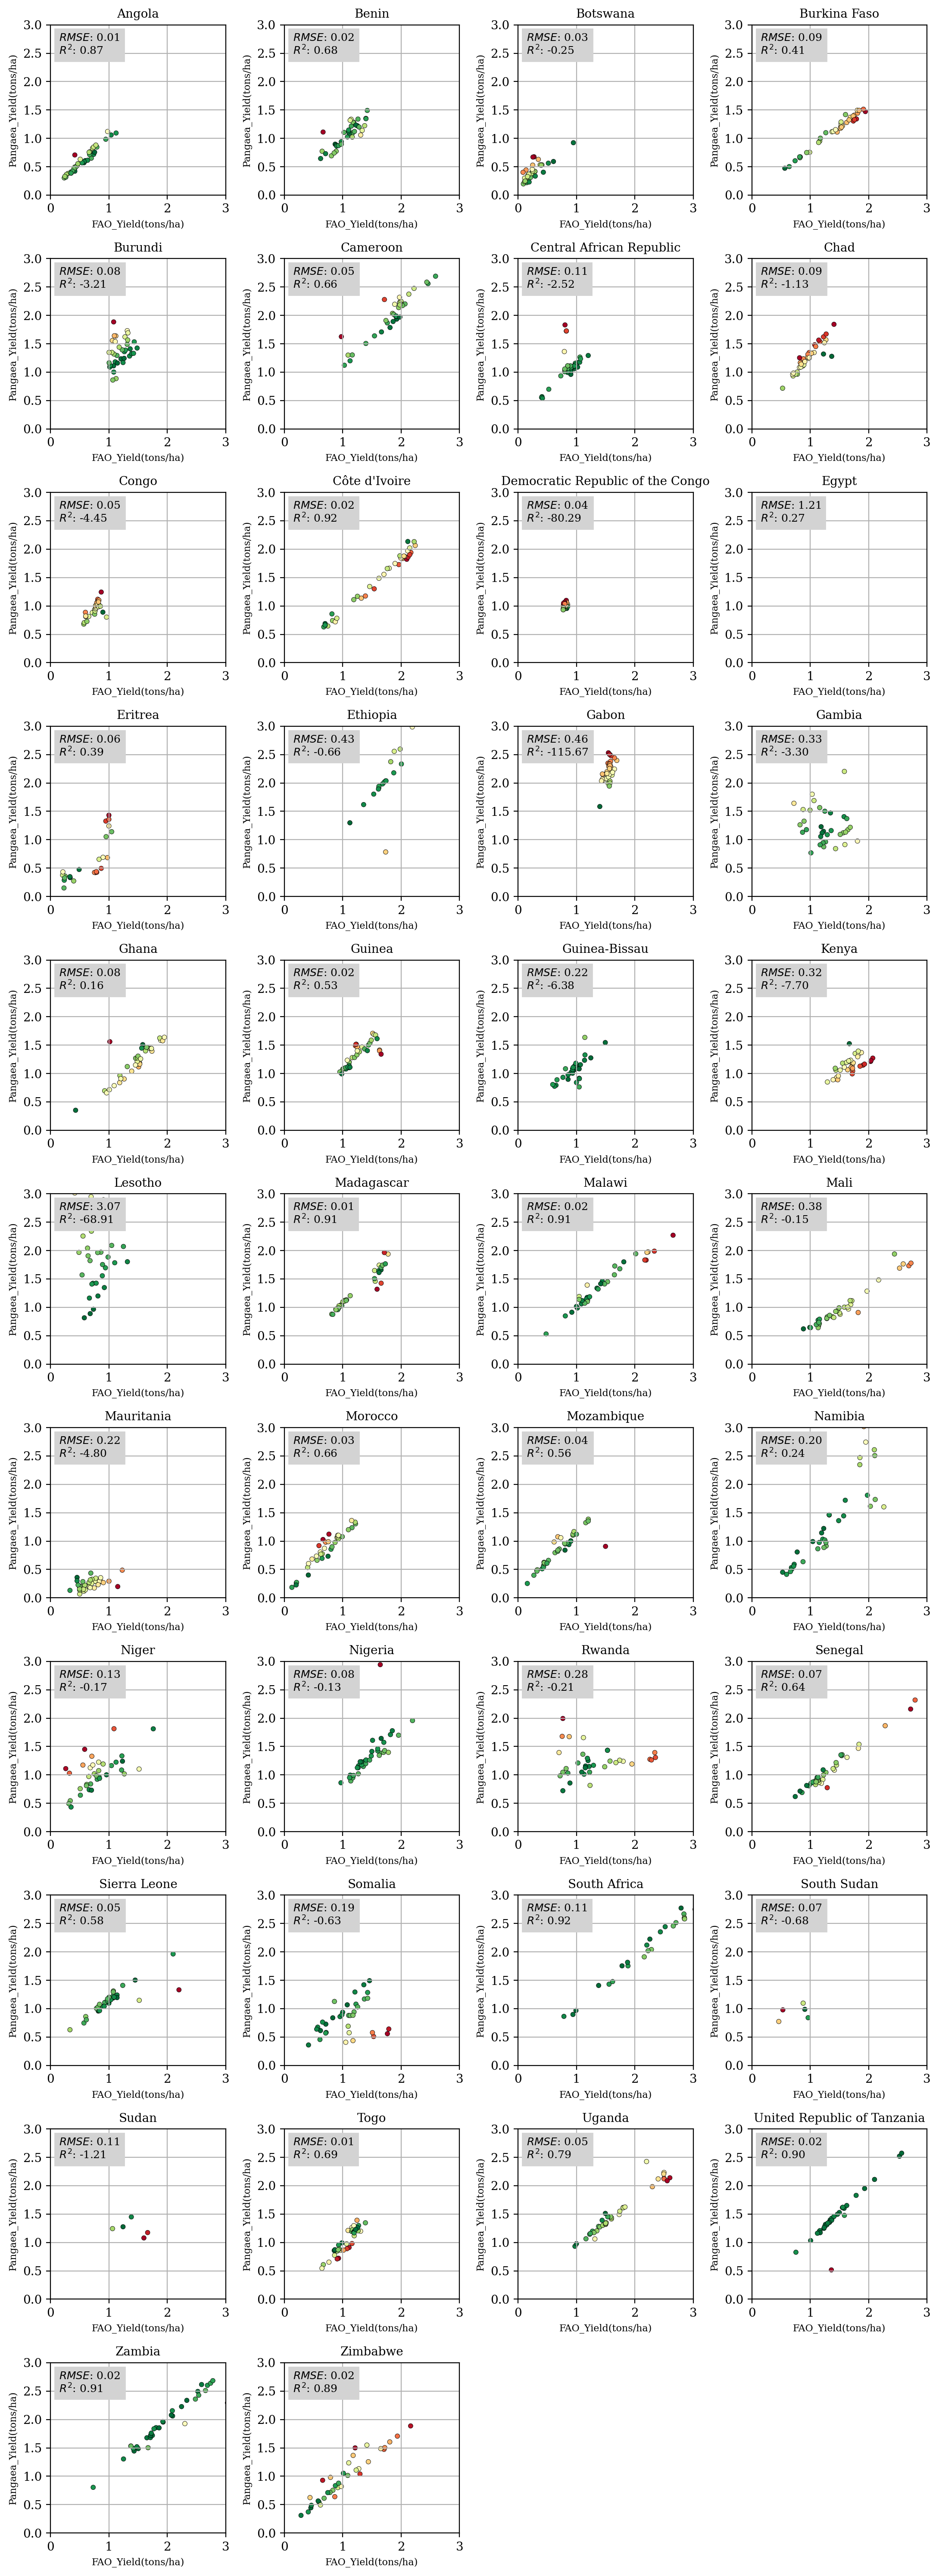

In [17]:
# Plot the scatterplot between FAO and Pangaea data
fig, axes = plt.subplots(ncols=4, nrows=11, figsize=(11, 30), dpi=200)
axes = axes.flatten()

for index, country in enumerate(merged_df["Area"].unique()):
    country_data = merged_df[merged_df["Area"]==country]
    country_data["Yield_Diff"] = np.abs(country_data["FAO_Yield(tons/ha)"]-country_data["Pangaea_Yield(tons/ha)"])

    # Calculate the R2 Score and RMSE
    r2 = np.round(r2_score(y_true=country_data["FAO_Yield(tons/ha)"], y_pred=country_data["Pangaea_Yield(tons/ha)"]), 2)
    rmse = mean_squared_error(y_true=country_data["FAO_Yield(tons/ha)"], y_pred=country_data["Pangaea_Yield(tons/ha)"])

    sns.scatterplot(data=country_data, x="FAO_Yield(tons/ha)", y="Pangaea_Yield(tons/ha)", hue="Yield_Diff",
                    palette="RdYlGn_r", s=15, edgecolor="black", ax=axes[index])
    
    axes[index].set_xlabel("FAO_Yield(tons/ha)", fontsize=8)
    axes[index].set_ylabel("Pangaea_Yield(tons/ha)", fontsize=8)
    axes[index].set_title(country, fontsize=10)
    axes[index].set_xlim([0, 3])
    axes[index].set_ylim([0, 3])
    axes[index].grid()

    axes[index].legend().remove()

    # Annotate the subplot with RMSE and R^2
    axes[index].text(0.05, 0.95, f'$RMSE$: {rmse:.2f}\n$R^2$: {r2:.2f}', 
                     transform=axes[index].transAxes, verticalalignment='top', backgroundcolor="lightgrey", fontsize=9)

# Turn off the unused axes
for ax in axes[len(merged_df["Area"].unique()):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()